# 探索性数据分析(EDA)

## 查看数据基本信息

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
data_fram = pd.read_csv('road_data_small.csv')
# 查看数据前 5 行
data_fram.head()

,dates,OBJs,ODs_1,ODs_2,depTimes,expPerf,staticPerf,grdyPerf,godPerf,distances,...,stmutC_grdyPath_3,YesterdayGrdyPerf,YesterdayGodPerf,YesterdayStaPerf,YesterdayExpPerf,Outputs14,Outputs7,Outputs3_1,Outputs3_2,Outputs3_3
0,4.19,1,1386,1821,16454,901.873155,943.341039,879.878944,802.674362,0.089257,...,0.475829,999.074209,955.166635,997.787702,986.738929,13,6,-1,0,-1
1,4.19,1,529,1199,14062,905.320230,650.077643,650.077643,650.077643,0.053294,...,0.550532,667.675168,585.119637,655.264699,585.119637,2,2,1,1,-1
2,4.19,1,716,990,13779,787.775655,864.166706,925.812156,767.183548,0.080272,...,0.756983,612.851744,601.668111,975.484821,700.256755,14,7,-1,-1,0
3,4.19,1,547,1456,14027,625.313098,683.213117,670.375942,623.874198,0.063568,...,0.512717,670.883400,641.749020,670.883400,641.749020,14,7,-1,-1,0
4,4.19,1,914,1073,14355,604.748398,618.476141,620.277530,595.945774,0.047176,...,0.289439,590.331899,590.331899,657.448103,611.118098,14,7,-1,-1,0


In [3]:
# 查看每个类别数量
data_fram['Outputs14'].value_counts()

14    235
13    211
12     94
1      88
7      84
6      68
4      40
2      33
8      30
10     29
11     27
9      23
5      22
3      16
Name: Outputs14, dtype: int64

In [4]:
# 每个类别的占比
data_Outputs14_list = data_fram['Outputs14'].tolist()

occupation_ratio_list = []
for i in range(14):
    occupation_ratio_list.append(data_Outputs14_list.count(i+1))

jk = sum(occupation_ratio_list)

occupation_ratio_list = [a / jk for a in occupation_ratio_list]
occupation_ratio = np.array(occupation_ratio_list)
occupation_ratio

array([0.088, 0.033, 0.016, 0.04 , 0.022, 0.068, 0.084, 0.03 , 0.023,
       0.029, 0.027, 0.094, 0.211, 0.235])

## 删除无用信息

In [5]:
# 删除多余分类标准
data_fram.drop(['Outputs7','Outputs3_1','Outputs3_2','Outputs3_3'],axis=1,inplace=True)

## 对数据进行分层采样

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2018)

for train_index, test_index in split.split(data_fram, data_fram['Outputs14']):
    train_data = data_fram.loc[train_index]
    test_data = data_fram.loc[test_index]

In [7]:
# 转换数据类型
train_data_numpy_ndarray = train_data.values
test_data_numpy_ndarray = test_data.values

In [16]:
X_train = train_data_numpy_ndarray[:,9:130].astype(float)
Y_train = train_data_numpy_ndarray[:,130].astype(int)
X_test = test_data_numpy_ndarray[:,9:130].astype(float)
Y_test = test_data_numpy_ndarray[:,130].astype(int)

Y_train = Y_train - 1
Y_test = Y_test - 1

In [17]:
from keras.utils import np_utils

Y_onehot_train = np_utils.to_categorical(Y_train)
Y_onehot_test = np_utils.to_categorical(Y_test)

In [18]:
from sklearn.preprocessing import StandardScaler
standar_s = StandardScaler()
# 特征标准化
X_train_std = standar_s.fit_transform(X_train)
X_test_std = standar_s.fit_transform(X_test)

# 实验

-----

In [19]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard

In [20]:
# 使用 tensorboard 辅助训练的函数
def train_model(model, X, Y, batch_size, epochs=100,
                shuffle=False, version=0, run_number=0):
    """
    Shorthand function for training a new model.
    This function names each run of the model
    using the TensorBoard naming conventions.
    
    Parameters
    ----------
    model: Keras model instance
        Compiled Keras model.
    X, Y: np.array
        Series of observations to be used in
        the training process.
    version: int
        Version of the model to run.
    run_number: int
        The number of the run. Used in case
        the same model version is run again.
    """
    hash = random.getrandbits(128)
    hex_code = '%032x' % hash
    model_name = 'road_classification_v{version}_run_{run_number}_{hex_code}'.format(
        version=version, run_number=run_number, hex_code=hex_code[:6])

    tensorboard = TensorBoard(log_dir='./logs/{}'.format(model_name))
    
    model_history = model.fit(
        x=X, y=Y,
        batch_size=batch_size, epochs=epochs,
        verbose=0, callbacks=[tensorboard],
        shuffle=shuffle)
    
    return model_history

# 实验一

In [21]:
def creat_model_1():
    model = Sequential()
    model.add(Dense(units=1024,input_dim=121))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=512))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=64))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(units=14))
    model.add(Activation('sigmoid',name='Dense_L'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [22]:
a_model_1 = creat_model_1()

In [23]:
train_model(a_model_1, X_train_std, Y_onehot_train,
            batch_size=64, epochs=20,shuffle=True,
            version=0, run_number=1
           )

In [24]:
a_model_1.evaluate(X_test_std,Y_onehot_test)

200/200 [==============================] - 0s 555us/step


[0.21953729569911956, 0.9278571224212646]

## 取输出层的值的方法

In [25]:
from keras.models import Model

L_output_model = Model(inputs=a_model_1.input,outputs=a_model_1.get_layer('Dense_L').output)

L_output_model_output = L_output_model.predict(X_test_std[:20000])

L_output_model_output.shape

(200, 14)

**自定义准确率函数**

In [26]:
# 查看预测的最大概率与 Y 的关系
a_sum = 0
for y_hat,y in zip(np.argmax(L_output_model_output,axis=1),Y_test[:20000]):
    if y_hat==y:
        a_sum+=1
print(a_sum/20000)

0.00375


In [27]:
# 查看 top-k 与 Y 的关系
b_sum = 0
for y_hat,y in zip(L_output_model_output,Y_test[:20000]):
    if y in y_hat.argsort()[-7:][::-1]:
        b_sum+=1
print(b_sum/20000)

0.00845


In [28]:
Y_onehot_test.shape

(200, 14)

## 加入先验信息（各个类别的比例）

In [29]:
# 查看 top-k 与 Y 的关系
c_sum = 0
for y_hat,y in zip(L_output_model_output,Y_test[:20000]):
    Res = [0 for i in range(14)]
    current_occupation_ratio = occupation_ratio.copy()
    y_hat_top_k = y_hat.argsort()[-2:][::-1]
    for top_i in y_hat_top_k:
        Res[top_i] = y_hat[top_i] 
    for index,i in enumerate(Res):
        if i==0:
            current_occupation_ratio[index]=0
    current_occupation_ratio = current_occupation_ratio / np.sum(current_occupation_ratio)
    Res_p = np.array(Res) * current_occupation_ratio
    # 归一化
    Res_p = Res / sum(Res)
    if np.random.choice(14, 1, p=Res_p)==y:
        c_sum+=1
print(c_sum/20000)

0.00285


# **混淆矩阵**

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
import matplotlib.pyplot as plt

In [32]:
conf_mx = confusion_matrix(Y_test[:20000],np.argmax(L_output_model_output,axis=1))

In [33]:
plt.rcParams['figure.figsize'] = (9,9) # 显示大小

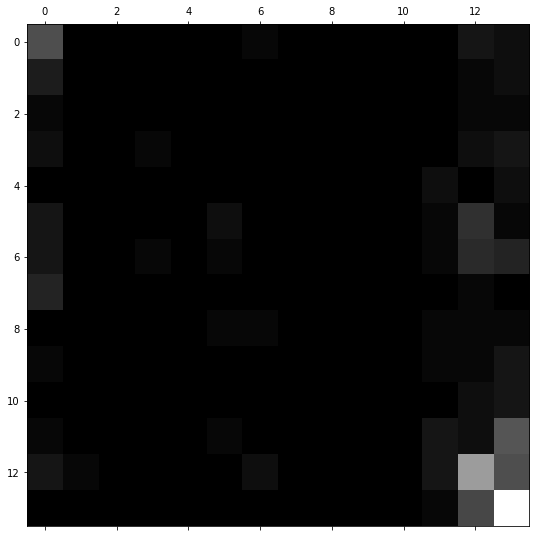

In [34]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

中间对角线表示正确分类的比例，如上图只有第

In [35]:
# 查看每个类别数量
data_fram['Outputs14'].value_counts()

14    235
13    211
12     94
1      88
7      84
6      68
4      40
2      33
8      30
10     29
11     27
9      23
5      22
3      16
Name: Outputs14, dtype: int64

# 实验二

## 创建模型

In [39]:
def create_model_2():
    model = Sequential()
    model.add(Dense(units=1024, kernel_initializer='he_normal',input_dim=121))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=512, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=256, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=128, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=64, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, kernel_initializer='he_normal'))
    model.add(Activation('selu'))
    model.add(Dense(units=14, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [40]:
a_model_2 = create_model_2()

## 训练模型

In [41]:
# 增加验证集模式，会减慢训练的速度
a_model_2.fit(X_train_std, Y_onehot_train, epochs=10, batch_size=256,verbose=1,validation_split=0.2,shuffle=True)

Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 2s 3ms/step - loss: 0.9550 - acc: 0.4932 - val_loss: 0.7479 - val_acc: 0.5304
Epoch 2/10
640/640 [==============================] - 0s 223us/step - loss: 0.8876 - acc: 0.5220 - val_loss: 0.7300 - val_acc: 0.5402
Epoch 3/10
640/640 [==============================] - 0s 211us/step - loss: 0.8445 - acc: 0.5315 - val_loss: 0.7016 - val_acc: 0.5705
Epoch 4/10
640/640 [==============================] - 0s 228us/step - loss: 0.8063 - acc: 0.5400 - val_loss: 0.6644 - val_acc: 0.6027
Epoch 5/10
640/640 [==============================] - 0s 227us/step - loss: 0.7643 - acc: 0.5544 - val_loss: 0.6329 - val_acc: 0.6429
Epoch 6/10
640/640 [==============================] - 0s 222us/step - loss: 0.7402 - acc: 0.5680 - val_loss: 0.6012 - val_acc: 0.6804
Epoch 7/10
640/640 [==============================] - 0s 227us/step - loss: 0.7038 - acc: 0.5959 - val_loss: 0.5756 - val_acc: 0.7027
Epoch 8/10
640/640

## 评估模型

In [42]:
a_model_2.evaluate(X_test_std,Y_onehot_test)

200/200 [==============================] - 0s 120us/step


[0.5185107135772705, 0.7453571462631225]

# 实验三

In [44]:
from keras import regularizers
def creat_model_3():
    model = Sequential()
    model.add(Dense(units=1024,input_dim=121,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=512,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=64,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(units=14,kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [45]:
a_model_3 = creat_model_3()

a_model_3.fit(X_train_std, Y_onehot_train, epochs=15, batch_size=256,verbose=1,shuffle=True)

Epoch 1/15
800/800 [==============================] - 1s 2ms/step - loss: 10.6819 - acc: 0.5030
Epoch 2/15
800/800 [==============================] - 0s 198us/step - loss: 9.1868 - acc: 0.5211
Epoch 3/15
800/800 [==============================] - 0s 188us/step - loss: 7.8823 - acc: 0.5407
Epoch 4/15
800/800 [==============================] - 0s 186us/step - loss: 6.7440 - acc: 0.5521
Epoch 5/15
800/800 [==============================] - 0s 185us/step - loss: 5.7583 - acc: 0.5605
Epoch 6/15
800/800 [==============================] - 0s 190us/step - loss: 4.9028 - acc: 0.5751
Epoch 7/15
800/800 [==============================] - 0s 185us/step - loss: 4.1781 - acc: 0.5844
Epoch 8/15
800/800 [==============================] - 0s 183us/step - loss: 3.5602 - acc: 0.6129
Epoch 9/15
800/800 [==============================] - 0s 190us/step - loss: 3.0413 - acc: 0.6255
Epoch 10/15
800/800 [==============================] - 0s 195us/step - loss: 2.6116 - acc: 0.6434
Epoch 11/15
800/800 [=========

In [46]:
a_model_3.evaluate(X_test_std,Y_onehot_test)

200/200 [==============================] - 0s 1ms/step


[1.2903024578094482, 0.8549999928474427]

# 实验四

In [47]:
from keras import regularizers
def creat_model_4():
    model = Sequential()
    model.add(Dense(units=1024,input_dim=121,kernel_regularizer=regularizers.l1(0.05)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=512,kernel_regularizer=regularizers.l1(0.05)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=64,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(units=14,kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [48]:
a_model_4 = creat_model_4()

a_model_4.fit(X_train_std, Y_onehot_train, epochs=15, batch_size=256,verbose=1,shuffle=True)

Epoch 1/15
800/800 [==============================] - 1s 2ms/step - loss: 1012.5248 - acc: 0.5029
Epoch 2/15
800/800 [==============================] - 0s 179us/step - loss: 890.3420 - acc: 0.5126
Epoch 3/15
800/800 [==============================] - 0s 184us/step - loss: 777.0180 - acc: 0.5164
Epoch 4/15
800/800 [==============================] - 0s 174us/step - loss: 672.1536 - acc: 0.5241
Epoch 5/15
800/800 [==============================] - 0s 191us/step - loss: 575.3077 - acc: 0.5303
Epoch 6/15
800/800 [==============================] - 0s 195us/step - loss: 486.4236 - acc: 0.5375
Epoch 7/15
800/800 [==============================] - 0s 203us/step - loss: 405.4184 - acc: 0.5440
Epoch 8/15
800/800 [==============================] - 0s 209us/step - loss: 332.1916 - acc: 0.5466
Epoch 9/15
800/800 [==============================] - 0s 193us/step - loss: 266.7009 - acc: 0.5655
Epoch 10/15
800/800 [==============================] - 0s 185us/step - loss: 208.9146 - acc: 0.5692
Epoch 11/1

In [49]:
a_model_4.evaluate(X_test_std,Y_onehot_test)

200/200 [==============================] - 0s 2ms/step


[32.14825424194336, 0.9289285445213318]

# 采用网格搜索方法寻找最优超参数

In [50]:
from keras.wrappers.scikit_learn import KerasClassifier

In [51]:
from sklearn.model_selection import GridSearchCV

## 网格搜索示例

In [52]:
def creat_dynamic_model():
    model = Sequential()
    model.add(Dense(units=1024,input_dim=121))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=512))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=64))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(units=14))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [53]:
dynamic_model = KerasClassifier(build_fn=creat_dynamic_model, verbose=0)

In [54]:
param_grid = {}

In [55]:
param_grid['epochs'] = [10,]
param_grid['batch_size'] = [256,]

In [56]:
grid = GridSearchCV(estimator=dynamic_model, param_grid=param_grid)

In [57]:
grid_result = grid.fit(X_train_std, Y_onehot_train)

In [58]:
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))

Best: 0.6513392896950245 using {'batch_size': 256, 'epochs': 10}


In [59]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

0.651339 (0.024750) with: {'batch_size': 256, 'epochs': 10}


# 搜索神经元个数

In [60]:
def creat_dynamic_model_neurons_number(num_neurons=128):
    model = Sequential()
    model.add(Dense(units=num_neurons,input_dim=121))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=num_neurons))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(units=256))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(units=128))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(units=14))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [61]:
dynamic_model_neurons_number = KerasClassifier(build_fn=creat_dynamic_model_neurons_number, verbose=0)

In [62]:
param_grid_neurons_number = {}

In [63]:
#param_grid['epochs'] = [10,]
#param_grid['batch_size'] = [256,]
param_grid_neurons_number['num_neurons'] = [512, 1024, 2048, 4096]

In [64]:
grid_neurons_number = GridSearchCV(estimator=dynamic_model_neurons_number, param_grid=param_grid_neurons_number)

In [65]:
grid_result_neurons_number = grid_neurons_number.fit(X_train_std, Y_onehot_train)

In [66]:
print('Best: {} using {}'.format(grid_neurons_number.best_score_, grid_neurons_number.best_params_))

Best: 0.6114285832643509 using {'num_neurons': 4096}


In [67]:
best_neurons_number_model = grid_result_neurons_number.best_estimator_

In [68]:
a_Y_hat = best_neurons_number_model.predict(X_test_std)

In [69]:
X_test_std.shape

(200, 121)

In [70]:
sum_g = 0
for y,y_hat in zip(Y_test,a_Y_hat):
    if y==y_hat:
        sum_g+=1
print(sum_g/20384)

0.0018642072213500786
